# Neural Network classification with PyTorch

Classification is a problem if predicting whether something is one thing or another (there can be multiple things as the options).

## 1. Make classification data and get it ready

In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
print(f'First 5 samples of X:\n {X[:5]}')
print(f'First 5 samples of y:\n {y[:5]}')

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [4]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({
    'X1': X[:, 0], 
     'X2': X[:, 1],
     'label': y
})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [5]:
# Check different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

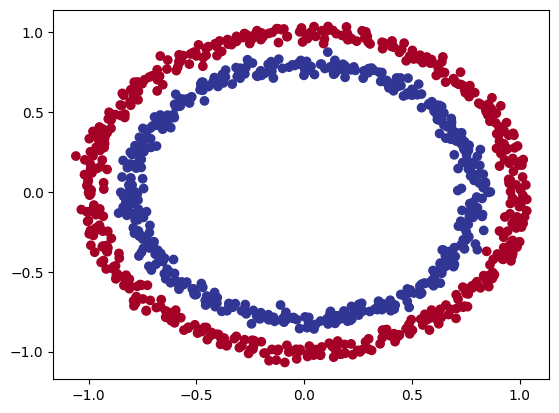

In [6]:
# Visualize, visualize, visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

Note: The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experimetal but still sizeable enough to rpactice the fundamentals.

### 1.1 Check input and output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
# view the firsr ezample of features and labels
X_sample = X[0]
y_sample = y[0]

print(f'Value for one sample of X: {X_sample}, and the same for y: {y_sample}')
print(f'Shape for one sample of X: {X_sample.shape}, and the same for y: {y_sample.shape}')

Value for one sample of X: [0.75424625 0.23148074], and the same for y: 1
Shape for one sample of X: (2,), and the same for y: ()


### 1.2 Turn data tinto tensors and create train and test splits

In [9]:
import torch
torch.__version__

'2.3.1+cu118'

In [10]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
# split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,  # 0.2 -> 20% of data will be test a & 80% will be train
                                                    random_state=42)

In [12]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and read dots.

to do so, we want to:
1. Setup divice agnostic code so our code will tun on an accelerator (GPU) if there is one
2. Constuct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [13]:
from torch import nn

# Make device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Now we'ne setup device agnostic code, let's create a model that:

1. Subclass `nn.Module` (almost all models in PyTorch subclass `nn.Module)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Define a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instatiate an instance of our model class and send it to the target `device`

In [14]:
# 1. Construct a model that subclasses nn.Module
class circleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a single feature (same shape as y)

        # self.two_linear_layers = nn.Sequential(
        #     nn.Linear(in_features=2, out_features=5),
        #     nn.Linear(in_features=5, out_features=1)
        # )

    # 3. Define a forward() method that outlines the forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output
        # return self.two_linear_layers(x)
    
# 4. Instatiate an instance of our model class and send it to the target device
model_0 = circleModelV0().to(device)
model_0


circleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [16]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features= 5),
    nn.Linear(in_features=5, out_features= 1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.5944,  0.1632],
                      [ 0.2018,  0.5823],
                      [-0.6378, -0.6084],
                      [-0.5236,  0.6368],
                      [-0.4018, -0.3770]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.1861, -0.6847,  0.2031,  0.6977, -0.3071], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.1802,  0.2200, -0.3891,  0.0879, -0.4203]], device='cuda:0')),
             ('1.bias', tensor([0.1117], device='cuda:0'))])

In [18]:
# Make predictions with the model
with torch.inference_mode():
    unstrained_preds = model_0(X_test.to(device))
print(f'Length of predictions: {len(unstrained_preds)}, shape: {unstrained_preds.shape}')
print(f'Length of test samples: {len(X_test)}, shape: {X_test.shape}')
print(f'\nFirst 10 predictions:\n{unstrained_preds[:10]}')
print(f'\nFirst 10 labels:\n{y_test[:10]}')

Length of predictions: 200, shape: torch.Size([200, 1])
Length of test samples: 200, shape: torch.Size([200, 2])

First 10 predictions:
tensor([[ 0.4059],
        [ 0.6951],
        [-0.3022],
        [ 0.6063],
        [-0.2226],
        [-0.0467],
        [ 0.7046],
        [ 0.5311],
        [-0.3044],
        [ 0.7154]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?    
Again... this is problem specific   
For example ofr regression you might want MAE or MSE (mean absolute error or mean squared error).   
For classification you might want binary cross entropy or categirical cross entropy (cross entropy).    

As a reminder, the loss function measure how *wrong* your models predictions are.   
Pytorch has many built-in options.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options.

In [19]:
# Setup the loss function
# loss_fn = nn.BCELoss # BCEWithLogitsLoss = requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

In [20]:
# calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correcr = torch.eq(y_true, y_pred).sum().item()
    acc = (correcr/len(y_pred)) * 100
    return acc

## Train model

To train our model, we're going to need to build a training loop:   

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimize step (gradient desent)

### 3.1 Going from raw logits -> prediction probabilties -> prediction labels

Our model outputs are going to be raw **logits**.
    
We can convert these **logits** into **prediction probabilties** by passing them to some kind fo activation function (e.g. sigmoid for binary classification and doftmax for multiclass classification)     
    
Then we can convert our model's predictions probabilites to **prediction labels** by either rounding them or taking the `argmax()`.

In [21]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.4059],
        [ 0.6951],
        [-0.3022],
        [ 0.6063],
        [-0.2226]], device='cuda:0')

In [22]:
# Use the sigmoid activation function on our model logits to turn the into predictions probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6001],
        [0.6671],
        [0.4250],
        [0.6471],
        [0.4446]], device='cuda:0')

For our prdictions prebabilties values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5 -> y=1 (class 1)
* `y_pred_probs` <> 0.5 -> y=0 (class 0)

In [23]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid od extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 0., 1., 0.], device='cuda:0')

### 3.2 Building a training and testing loop

In [24]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training adn evaluation loop
for epoch in range(epochs):
    # Training
    model_0.train()

    ## 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    ## 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # nn.BCELoss expects prediction probabilition as input
    #                y_train)
    
    loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
                   y_train)
    
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    ## 3. Optimizer zero grad
    optimizer.zero_grad()

    ## 4. Loss backward (backpropagation)
    loss.backward()

    ## 5. Optimizer step
    optimizer.step()
    
    # Testing
    model_0.eval()

    with torch.inference_mode():
        ## 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        ## 2. Calculate test loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    ## Print out what's happenin'
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.5f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}%')


Epoch: 0 | Loss: 0.71346 | Accuracy: 51.62500% | Test loss: 0.73642 | Test accuracy: 47.00000%
Epoch: 100 | Loss: 0.70734 | Accuracy: 51.87500% | Test loss: 0.72650 | Test accuracy: 46.50000%
Epoch: 200 | Loss: 0.70334 | Accuracy: 51.62500% | Test loss: 0.71963 | Test accuracy: 46.00000%
Epoch: 300 | Loss: 0.70059 | Accuracy: 51.75000% | Test loss: 0.71465 | Test accuracy: 46.00000%
Epoch: 400 | Loss: 0.69865 | Accuracy: 51.50000% | Test loss: 0.71091 | Test accuracy: 46.00000%
Epoch: 500 | Loss: 0.69725 | Accuracy: 51.75000% | Test loss: 0.70803 | Test accuracy: 46.00000%
Epoch: 600 | Loss: 0.69621 | Accuracy: 51.75000% | Test loss: 0.70577 | Test accuracy: 45.50000%
Epoch: 700 | Loss: 0.69544 | Accuracy: 51.87500% | Test loss: 0.70396 | Test accuracy: 45.50000%
Epoch: 800 | Loss: 0.69487 | Accuracy: 51.87500% | Test loss: 0.70250 | Test accuracy: 46.00000%
Epoch: 900 | Loss: 0.69443 | Accuracy: 51.87500% | Test loss: 0.70131 | Test accuracy: 46.00000%


## 4. Make predictions and evaluate the model

From the metrics is looks like our model isn't learning anything...

So to inspect it let's make some predictions and make them visual!

In other words, "Visualize, visualize, visualize!"

To do so, wwe're goining to inport a function called `plot_decision_boundary()`


In [25]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo(if it's not already download)
if Path('helper_funstions.py').is_file():
    print('helper_funstions.py already exists, skipping download')
else:
    print('Download helper_funstions.py')
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download helper_funstions.py


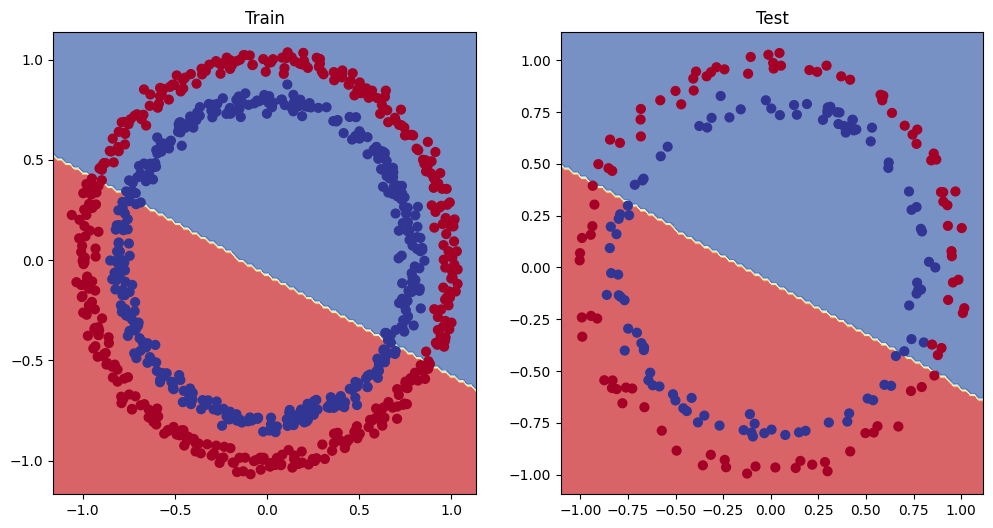

In [26]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. IMproving a model (from a model perspective)

* Add mode layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from a model's perspective because they deal directcly with the model, rather than the data.

And because these options are all values we (as machine learing engineers and data scientists) can chage, they are reffered as **hyperparameters**.

Let's try and improve our model by:
* Adding moder hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 1000 -> 10000


In [27]:
class circleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x): # note: always make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations leverages speed ups where possible behind the scenes
    
model_1 = circleModelV1().to(device)
model_1

circleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [28]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.6233,  0.1079],
                      [ 0.1791,  0.5387],
                      [-0.5981, -0.5320],
                      [-0.5249,  0.6344],
                      [-0.3531, -0.2834]])),
             ('0.bias', tensor([ 0.1723, -0.6964,  0.2236,  0.6963, -0.2826])),
             ('1.weight',
              tensor([[ 0.2184,  0.0844, -0.1548, -0.0624, -0.2523]])),
             ('1.bias', tensor([0.0406]))])

In [29]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.122

In [30]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

In [31]:
# write a training and evaluate loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 10000

# Put data an the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(1, epochs+1):
    # Training
    model_1.train()

    ## 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probabilities -> prediction labels

    ## 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    ## 3. Optimizer zero grad
    optimizer.zero_grad()

    ## 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Testing
    model_1.eval()

    with torch.inference_mode():
        ## 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        ## 2. Calculate test loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    ## Print out what's happenin'
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.5f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}%')


Epoch: 100 | Loss: 0.69369 | Accuracy: 50.25000% | Test loss: 0.69269 | Test accuracy: 50.00000%
Epoch: 200 | Loss: 0.69352 | Accuracy: 50.12500% | Test loss: 0.69282 | Test accuracy: 50.00000%
Epoch: 300 | Loss: 0.69339 | Accuracy: 50.50000% | Test loss: 0.69295 | Test accuracy: 49.00000%
Epoch: 400 | Loss: 0.69329 | Accuracy: 50.37500% | Test loss: 0.69309 | Test accuracy: 48.50000%
Epoch: 500 | Loss: 0.69322 | Accuracy: 49.87500% | Test loss: 0.69322 | Test accuracy: 49.50000%
Epoch: 600 | Loss: 0.69317 | Accuracy: 49.50000% | Test loss: 0.69335 | Test accuracy: 54.00000%
Epoch: 700 | Loss: 0.69313 | Accuracy: 49.37500% | Test loss: 0.69347 | Test accuracy: 51.00000%
Epoch: 800 | Loss: 0.69309 | Accuracy: 50.00000% | Test loss: 0.69358 | Test accuracy: 51.00000%
Epoch: 900 | Loss: 0.69307 | Accuracy: 50.62500% | Test loss: 0.69368 | Test accuracy: 47.50000%
Epoch: 1000 | Loss: 0.69305 | Accuracy: 50.50000% | Test loss: 0.69378 | Test accuracy: 49.00000%
Epoch: 1100 | Loss: 0.69303 |

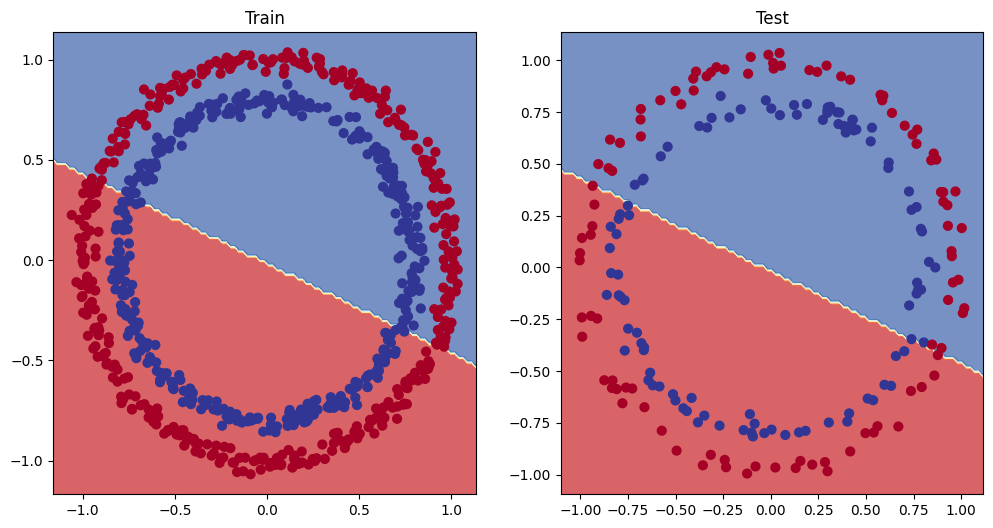

In [32]:
# Plot decision boundary the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Prepairing data to see if our model can fit a straight line

One way to troubleshoot to a longer problem is to test out a smaller preblem.

In [33]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0 
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regressio formula (without option)

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [34]:
# Create train data and test data
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression  = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression  = X_regression[train_split:], y_regression[train_split:]

# Check the lengths od each
len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

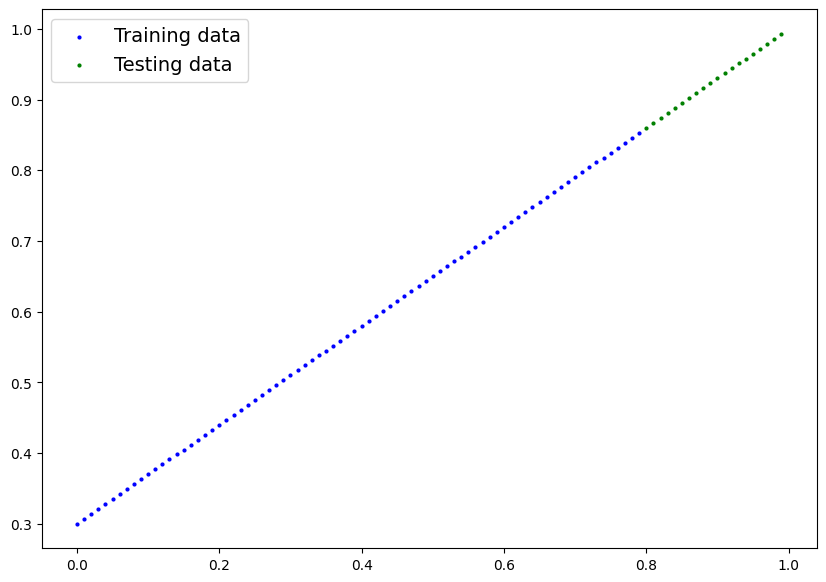

In [35]:
plot_predictions(train_data=X_train_regression, train_labels=y_train_regression,
                 test_data=X_test_regression, test_labels=y_test_regression)

### 5.2 Adjusting `model_1` to fit a straight line

In [36]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10), 
    nn.Linear(in_features=10, out_features=10), 
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [37]:
# Loss and optimizer
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.0001)

In [38]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 20000

# Put data an the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(1, epochs+1):
    model_2.train()

    ## 1. Forward pass
    y_pred = model_2(X_train_regression)

    ## 2. Calculate loss/accuracy
    loss = loss_fn(y_pred, y_train_regression)

    ## 3. Optimizer zero grad
    optimizer.zero_grad()

    ## 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Testing
    model_2.eval()
    with torch.inference_mode():
        ## 1. Forward pass
        test_pred = model_2(X_test_regression)

        ## 2. Calculate test loss/accuracy
        test_loss = loss_fn(test_pred, y_test_regression)

    ## Print out what's happenin'
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}')


Epoch: 100 | Loss: 0.72254 | Test loss: 0.91115
Epoch: 200 | Loss: 0.68543 | Test loss: 0.86892
Epoch: 300 | Loss: 0.64885 | Test loss: 0.82720
Epoch: 400 | Loss: 0.61273 | Test loss: 0.78592
Epoch: 500 | Loss: 0.57704 | Test loss: 0.74503
Epoch: 600 | Loss: 0.54172 | Test loss: 0.70447
Epoch: 700 | Loss: 0.50671 | Test loss: 0.66416
Epoch: 800 | Loss: 0.47197 | Test loss: 0.62406
Epoch: 900 | Loss: 0.43744 | Test loss: 0.58411
Epoch: 1000 | Loss: 0.40309 | Test loss: 0.54425
Epoch: 1100 | Loss: 0.36885 | Test loss: 0.50443
Epoch: 1200 | Loss: 0.33470 | Test loss: 0.46458
Epoch: 1300 | Loss: 0.30057 | Test loss: 0.42465
Epoch: 1400 | Loss: 0.26642 | Test loss: 0.38459
Epoch: 1500 | Loss: 0.23221 | Test loss: 0.34434
Epoch: 1600 | Loss: 0.19789 | Test loss: 0.30385
Epoch: 1700 | Loss: 0.16341 | Test loss: 0.26305
Epoch: 1800 | Loss: 0.12873 | Test loss: 0.22190
Epoch: 1900 | Loss: 0.09380 | Test loss: 0.18034
Epoch: 2000 | Loss: 0.05901 | Test loss: 0.13853
Epoch: 2100 | Loss: 0.03795 |

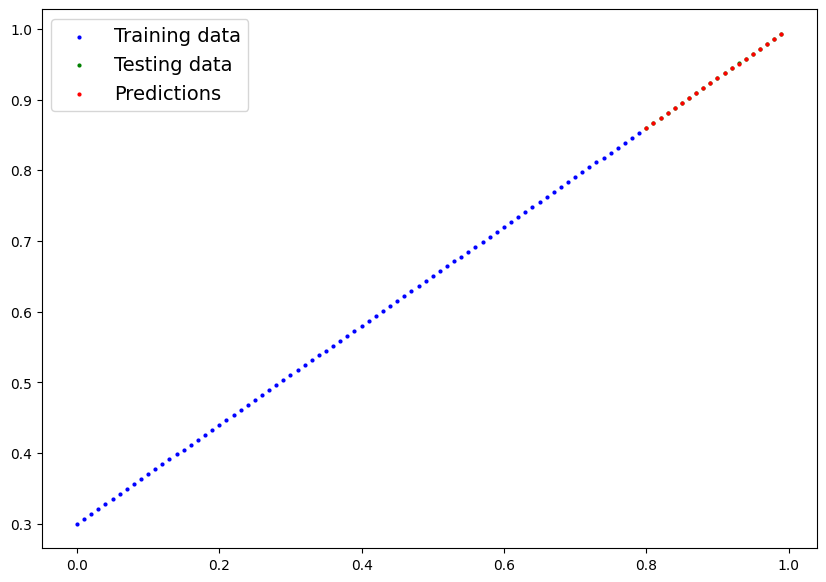

In [39]:
# Turn on evaluation mode
model_2.eval()

# Make prdictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(), train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(), test_labels=y_test_regression.cpu(), 
                 predictions=y_preds.cpu())

## 6. The missing piece: non-linearity
"What patterns could you draw if you were given an infinite amount of a straight and non-straight lines?"   
Or in machine learning terms, an infinite (but really it is finit) of linear and non-linear functions?

### 6.1 Recreating non-linear data (red and blue circles)

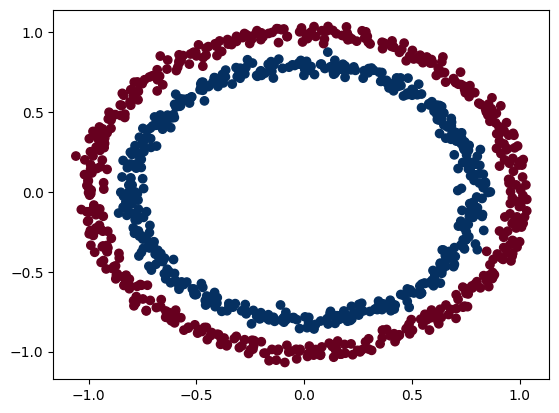

In [40]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)

In [41]:
# Convert adta to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42     
                                                    )
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity
* Linear = straight linear
* Non-linear = nonstraight lines

In [42]:
# Build a model with non-linear activation functions
from torch import nn
class circleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Where should we put our non-linear activation functions?
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_3 = circleModelV2().to(device)
model_3

circleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [43]:
# Setup liss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.01)

### 6.3 Training a model with non-learity

In [44]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 20000

for epoch in range(1, epochs+1):
    ### Taining
    model_3.train()

    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate the loss
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss (takes in logits as first input)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimzer
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, 
                            y_pred=test_pred)
        
    # Print out what's this happenin'
    if epoch % 1000 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.5f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}%')

Epoch: 1000 | Loss: 0.69115 | Accuracy: 53.00000% | Test loss: 0.69104 | Test accuracy: 52.50000%
Epoch: 2000 | Loss: 0.68977 | Accuracy: 53.37500% | Test loss: 0.68941 | Test accuracy: 55.00000%
Epoch: 3000 | Loss: 0.68795 | Accuracy: 53.00000% | Test loss: 0.68725 | Test accuracy: 56.00000%
Epoch: 4000 | Loss: 0.68516 | Accuracy: 52.75000% | Test loss: 0.68414 | Test accuracy: 56.50000%
Epoch: 5000 | Loss: 0.68100 | Accuracy: 52.75000% | Test loss: 0.67944 | Test accuracy: 56.50000%
Epoch: 6000 | Loss: 0.67511 | Accuracy: 54.50000% | Test loss: 0.67288 | Test accuracy: 56.00000%
Epoch: 7000 | Loss: 0.66651 | Accuracy: 58.37500% | Test loss: 0.66324 | Test accuracy: 59.00000%
Epoch: 8000 | Loss: 0.65142 | Accuracy: 64.00000% | Test loss: 0.64757 | Test accuracy: 67.50000%
Epoch: 9000 | Loss: 0.62320 | Accuracy: 74.00000% | Test loss: 0.62140 | Test accuracy: 79.00000%
Epoch: 10000 | Loss: 0.56727 | Accuracy: 88.00000% | Test loss: 0.57358 | Test accuracy: 86.50000%
Epoch: 11000 | Loss

### 6.4 Evaluationg a model trained with non-linear activation funvtions

In [45]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_pred = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_pred[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

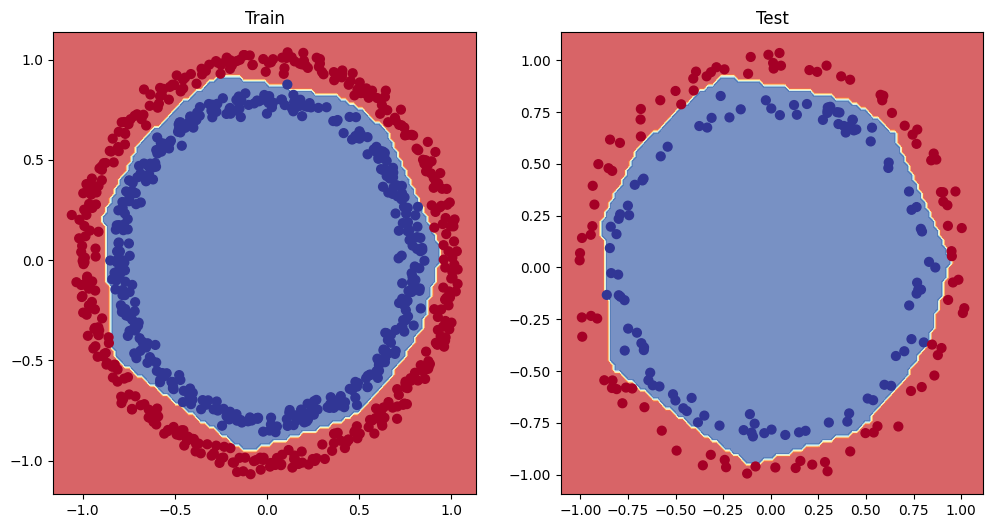

In [46]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicationg non-linear activation functions
Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.  
and these tools are linear & non-linear functions.

In [47]:
# Create a tensor
A = torch.arange(-10, 10, 1)
A.dtype

torch.int64

In [48]:
A

tensor([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,
          4,   5,   6,   7,   8,   9])

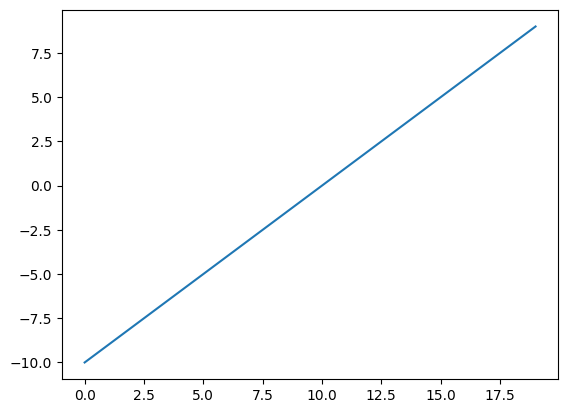

In [49]:
# Visualize the tensor
plt.plot(A)

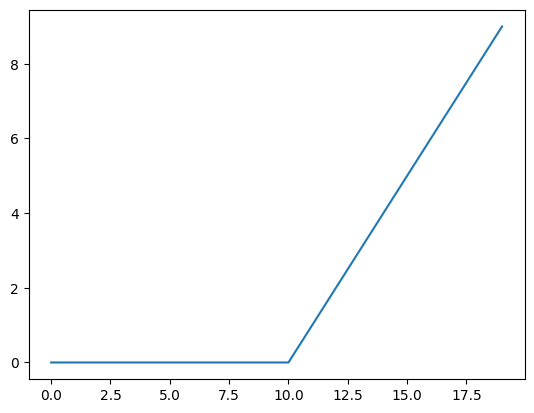

In [50]:
plt.plot(torch.relu(A))

In [51]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x) # inputs must be tensors

relu(A)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

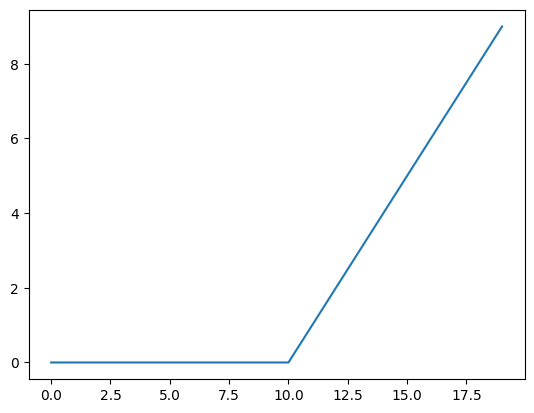

In [52]:
plt.plot(relu(A))

In [53]:
# Now let's do the same for sigmoid
def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(-x))

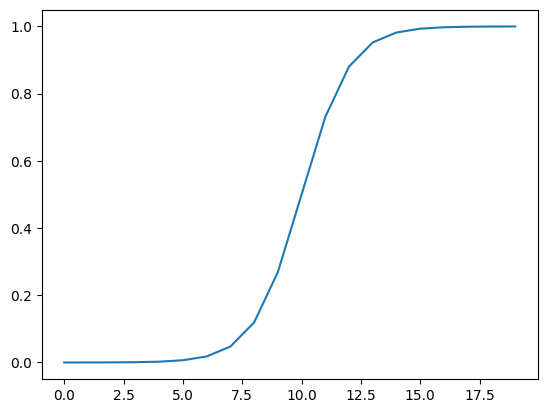

In [54]:
plt.plot(sigmoid(A))

## 8. Putting it all together with a multi-class classification problem
* Binary classification = one thing or another (cat vs dog, spam vs not spam, fraud or not fraud)
* Multi-class classification = more than inr thing or another (cat vs dog vs chicken)

### 8.1 Creating a toy multi-class dataset

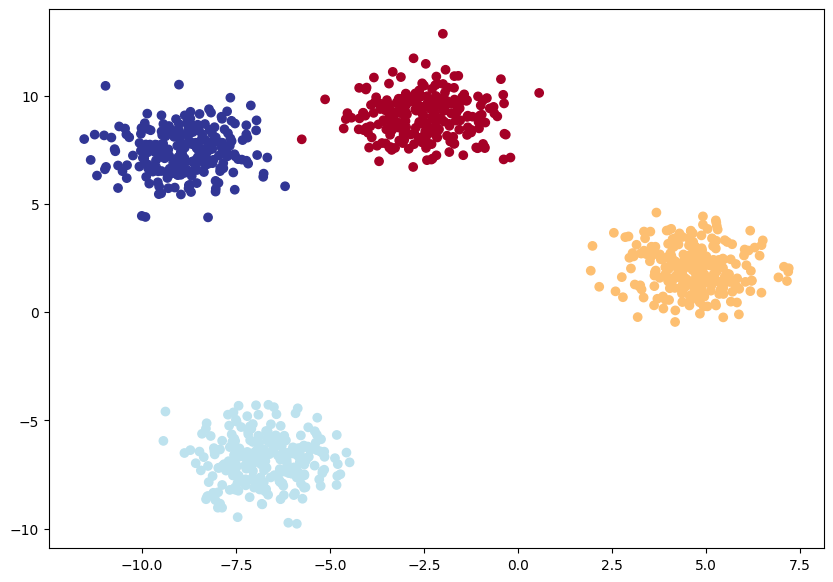

In [55]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000, 
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES, 
                            cluster_std=1, # give the clusters a little shake up 
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, 
                                                                        y_blob, 
                                                                        test_size=0.2, 
                                                                        random_state=RANDOM_SEED)

# 4. Plot data (visualize, visualize, visualize)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Buliding a multi-class classification model in PyTorch|

In [56]:
# create device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [57]:
# Build a multi-class classification model
class blobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes multi-class classification model.
        
        Args:
            input_features (int): Number of input features to the model
            output_features (int): Number of output features (number of output classes)
            hidden_units (int): Number of hidden units between layers, default 8
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)
    
model_4 = blobModel(input_features=2, 
                    output_features= 4, 
                    hidden_units=8).to(device)
model_4

blobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create aloss function and an optimizer for a multi-class classification model

In [58]:
# Create a loss functions for muti-lcass classification - loss function measures how wrong our model's preditions are
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for muti-lcass classification - optimizer updataes our model parameters to try and reduce the loss
optimizer = torch.optim.SGD(params=model_4.parameters(), 
                            lr=0.01) # learning rate is a hyperparameter you can change

### 8.4 Getting prediction probabilities for a multi-class PyTorch model
In order to evaluate and train and test our model, we need to convert our model's outpus (logits) to prediction probabilties and then to prediction labels.     
Logits (raw output of the model) -> Pred pros (use `torch.softmax`) -> pred labels (take the argmax of the prediction probabilities)

In [59]:
# Let's gt some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))
y_logits[:10]

tensor([[-0.7189, -0.6782, -1.4654, -1.0904],
        [-0.1043, -0.9593, -0.6114, -0.1405],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4796, -0.5497, -1.0410, -0.7695],
        [-0.2697, -1.2876, -1.0842, -0.3385],
        [-0.1383, -1.0363, -0.6852, -0.1579],
        [ 0.2214, -0.2573,  0.1889,  0.0081],
        [-0.2149, -1.1788, -0.9279, -0.2732],
        [ 0.2511, -0.2391,  0.1835, -0.0032],
        [-0.2244, -1.1972, -0.9561, -0.2856]], device='cuda:0')

In [60]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [61]:
# cpnvert our model's logit outputs to prediction probabiloties
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7189, -0.6782, -1.4654, -1.0904],
        [-0.1043, -0.9593, -0.6114, -0.1405],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4796, -0.5497, -1.0410, -0.7695],
        [-0.2697, -1.2876, -1.0842, -0.3385]], device='cuda:0')
tensor([[0.3120, 0.3249, 0.1479, 0.2152],
        [0.3342, 0.1421, 0.2013, 0.3224],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3076, 0.2868, 0.1754, 0.2302],
        [0.3653, 0.1320, 0.1618, 0.3410]], device='cuda:0')


In [62]:
# convert our mode;'s prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model

In [63]:
# Fit the multi-class model to the data
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
epochs = 20000

for epoch in range(1, epochs+1):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate the loss
    loss = loss_fn(y_logits, y_blob_train) # BCEWithLogitsLoss (takes in logits as first input)
    acc = accuracy_fn(y_true=y_blob_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimzer
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)


        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, 
                            y_pred=test_pred)
        
    # Print out what's this happenin'
    if epoch % 1000 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.4f} | Accuracy: {acc:.2f}% | Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.2f}%')

Epoch: 1000 | Loss: 0.0099 | Accuracy: 99.88% | Test loss: 0.0082 | Test accuracy: 100.00%
Epoch: 2000 | Loss: 0.0046 | Accuracy: 99.88% | Test loss: 0.0032 | Test accuracy: 100.00%
Epoch: 3000 | Loss: 0.0034 | Accuracy: 99.88% | Test loss: 0.0021 | Test accuracy: 100.00%
Epoch: 4000 | Loss: 0.0028 | Accuracy: 99.88% | Test loss: 0.0016 | Test accuracy: 100.00%
Epoch: 5000 | Loss: 0.0025 | Accuracy: 99.88% | Test loss: 0.0013 | Test accuracy: 100.00%
Epoch: 6000 | Loss: 0.0023 | Accuracy: 99.88% | Test loss: 0.0012 | Test accuracy: 100.00%
Epoch: 7000 | Loss: 0.0021 | Accuracy: 99.88% | Test loss: 0.0010 | Test accuracy: 100.00%
Epoch: 8000 | Loss: 0.0020 | Accuracy: 99.88% | Test loss: 0.0009 | Test accuracy: 100.00%
Epoch: 9000 | Loss: 0.0019 | Accuracy: 99.88% | Test loss: 0.0009 | Test accuracy: 100.00%
Epoch: 10000 | Loss: 0.0018 | Accuracy: 99.88% | Test loss: 0.0008 | Test accuracy: 100.00%
Epoch: 11000 | Loss: 0.0018 | Accuracy: 99.88% | Test loss: 0.0008 | Test accuracy: 100.0

In [64]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[ -1.7639,  10.4155,  -9.6517, -12.4519],
        [ -4.3711,  -8.5851,  -5.2007,   6.2669],
        [ -6.3257,  -6.5126,   5.9711,  -4.3332],
        [ -1.9924,   7.8734,  -6.2495,  -8.4091],
        [  8.6890,  -1.0677, -10.8781, -12.3309],
        [ -5.1512,  -9.6870,  -5.6667,   7.0715],
        [ -5.8139,  -5.9021,   5.4339,  -3.8176],
        [  7.7152,  -4.2688,  -9.0214,  -8.0860],
        [ -7.4775,  -7.6940,   6.9227,  -5.1491],
        [  7.9942,  -3.0797,  -9.5653,  -9.5201]], device='cuda:0')

In [65]:
# Go from logits -> Prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs

tensor([[5.1347e-06, 9.9999e-01, 1.9271e-09, 1.1716e-10],
        [2.3986e-05, 3.5469e-07, 1.0463e-05, 9.9997e-01],
        [4.5660e-06, 3.7877e-06, 9.9996e-01, 3.3489e-05],
        [5.1918e-05, 9.9995e-01, 7.3535e-07, 8.4841e-08],
        [9.9994e-01, 5.7901e-05, 3.1776e-09, 7.4333e-10],
        [4.9172e-06, 5.2707e-08, 2.9366e-06, 9.9999e-01],
        [1.3034e-05, 1.1935e-05, 9.9988e-01, 9.5956e-05],
        [9.9999e-01, 6.2433e-06, 5.3878e-08, 1.3730e-07],
        [5.5731e-07, 4.4879e-07, 9.9999e-01, 5.7187e-06],
        [9.9998e-01, 1.5511e-05, 2.3660e-08, 2.4753e-08],
        [9.9999e-01, 7.6200e-06, 3.9016e-07, 3.2563e-06],
        [1.0748e-06, 1.0000e+00, 2.1501e-10, 1.0946e-11],
        [9.9998e-01, 2.2312e-05, 4.3832e-09, 2.0306e-09],
        [1.0000e+00, 3.6811e-06, 6.6383e-09, 1.1887e-08],
        [1.0000e+00, 3.4925e-06, 1.7507e-09, 2.0694e-09],
        [1.0809e-04, 1.2629e-06, 2.0805e-05, 9.9987e-01],
        [1.7758e-05, 2.6718e-07, 9.9348e-06, 9.9997e-01],
        [4.232

In [66]:
# Go from pred rpobs to pred labels
y_pred = torch.argmax(y_pred_probs, dim=1)
y_pred

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

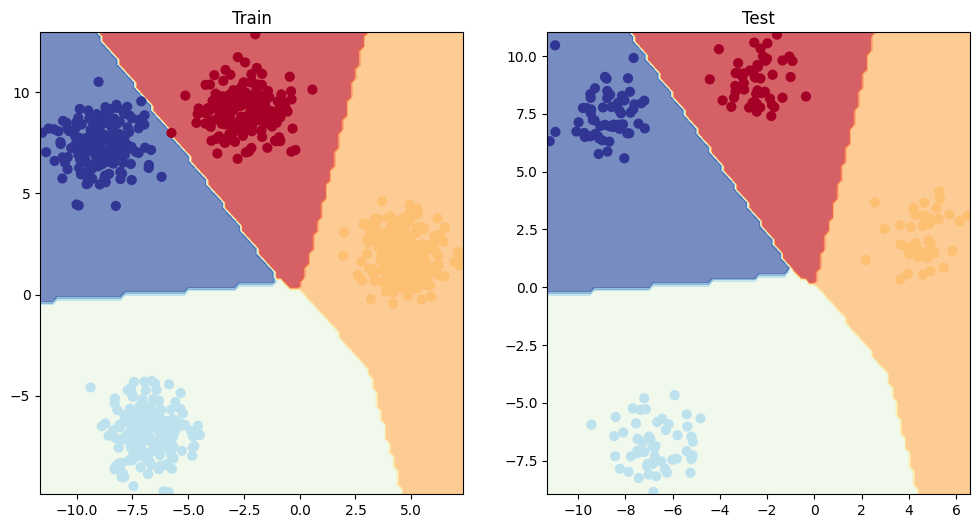

In [67]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## A few more classification metrics... (to evaluate our classification model)
* Accuracy - out of 100 samples, how many does our model get right?
* Precision
* Recall
* F1-socre
* Confusion Metrix
* Classification report

See this article ofr when to use precision/recall - https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

If you wnat access to a lot of PyTroch metrix, see Torchmetirx

In [68]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetric_accuracy(y_pred, y_blob_test)

tensor(1., device='cuda:0')